# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

# Display the head of the dataframe
#display(data.head())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [3]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [43,47,58]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,630,11095,23998,787,9529,72
1,44466,54259,55571,7782,24171,6465
2,13779,1970,1648,596,227,436


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

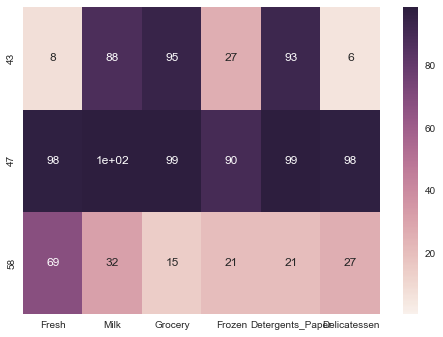

In [4]:
# Create a heatmap to understand samples' percentiles for each category
import seaborn as sns
# Calculate the percentiles for the whole data set
category_percentiles = data.rank(pct=True)
# Convert to Percentages
category_percentiles = 100*category_percentiles.round(decimals=2)
# Isolate the three samples
category_percentiles = category_percentiles.iloc[indices]
# Plot the heatmap
sns.heatmap(category_percentiles, vmin=1, vmax=99, annot=True)

**Answer:**
Sample 0: A Popular but Small Family Restaurant OR a Large Gas Station Convenience Store 
Largest Spend on Grocery and Milk (88th and 95th percentile of the data set) but there is a presumably a high volume of traffic because the Detergents/Paper property is in the 93rd percentile.

Sample 1: A Large Supermarket 
All categories are above the 90th percentile which indicates that the type needs to match the scale of use or resale.

Sample 2: A Farmer's Market 
All categories are hovering near or below the 25 percentile except Fresh, which is at the 69th percentile. This unique unbalancing indicates that there is little use for or sale of other items, and a specialization in the one.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [9]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
pull_label = 'Grocery'
new_labels = data[pull_label]
new_data = data.drop([pull_label],axis = 1)

# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, new_labels, test_size=0.25, random_state=0)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=17)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print "Score for test set for label '{0}' is {1:.4f}.".format(pull_label, score)

Score for test set for label 'Grocery' is 0.6624.


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** I tried Frozen (R^2 = 0.1661), Fresh (-0.3221), Detergents_Paper (0.6648) and Grocery (0.6624). Of the four both Detergents_Paper and Grocery were able to be predicted based on the remaining categories. This suggests that they are not good independents feature for predicting spending habits so are less valuable categories for our overall study. We could consider them good candidates for feature reduction. The other features that cannot be predicted by the remaining data are far better candidates, especially Fresh with it's negative R^2 value, for leading our feature set in importance and therefore should be kept for our customers spending model.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

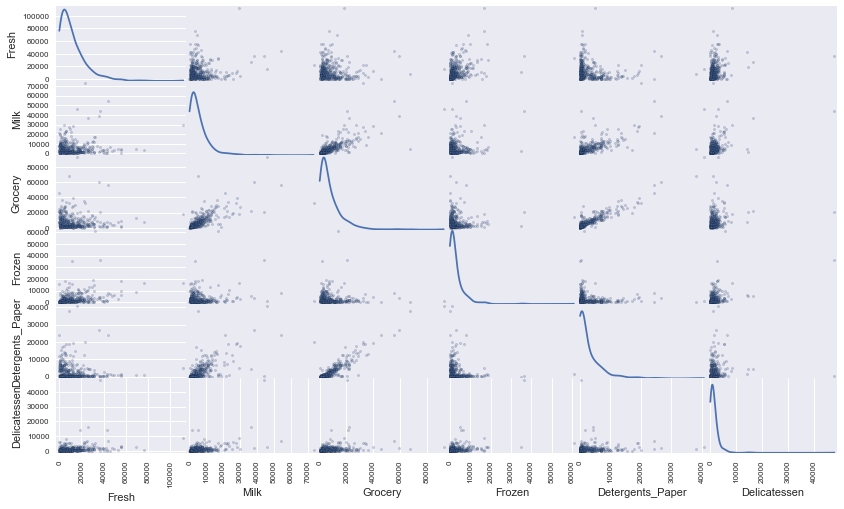

In [6]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**
Grocery to Detergents_Paper shows a clear correlation and less so but still some correlation can be seen in Grocery to Milk and Milk to Detergents_Paper. The relationships between those features are linear in nature - the majority of points lie close to a line that can be drawn from near the origin to the the upper right. The scatter plot patterns confirm our suspicions of Grocery and Detergents_Paper being poor independent features and good candidates for feature reduction. Because they are each also somewhat correlated to Milk as well, this should increase our confidence in our assessment of their value. 

Across all of our scatterplots, we have a heavy weighting of the positions near the Y Axis and the diagonal graphs of the KDE Density Curve are skewed to the left i.e. a Positive Skew with a narrow peak. The data is not normally distributed for any of the features with Fresh the closest to a normal distribution.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C171BE0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000DD1D240>]], dtype=object)

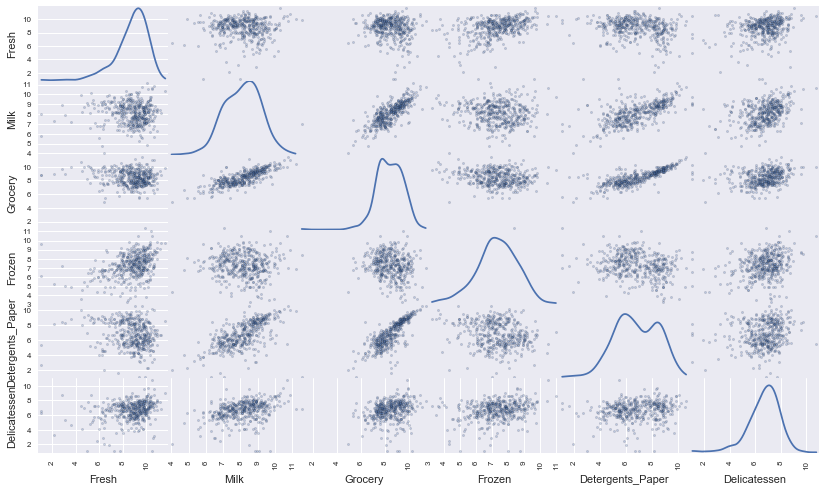

In [10]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [11]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6.445720,9.314250,10.085726,6.668228,9.162095,4.276666
1,10.702480,10.901524,10.925417,8.959569,10.092909,8.774158
2,9.530901,7.585789,7.407318,6.390241,5.424950,6.077642


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [12]:
# Create a variable to store all indices
remove = []
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25, axis=0)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75, axis=0)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    #display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    #Add indices conditionally
    remove.extend(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.tolist())

    
# OPTIONAL: Select the indices for data points you wish to remove
# Option A: Remove All Outliers
outliersA  = list(set(remove))
print "All outliers: " + str(outliersA)
# Option B: Remove Only Outliers that Repeat
from collections import Counter
outliersB = [item for item, count in Counter(remove).iteritems() if count > 1]
print "Repeated outliers: " + str(outliersB)

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliersB]).reset_index(drop = True)
#display(good_data)

Data points considered outliers for the feature 'Fresh':
Data points considered outliers for the feature 'Milk':
Data points considered outliers for the feature 'Grocery':
Data points considered outliers for the feature 'Frozen':
Data points considered outliers for the feature 'Detergents_Paper':
Data points considered outliers for the feature 'Delicatessen':
All outliers: [128, 193, 264, 137, 142, 145, 154, 412, 285, 161, 420, 38, 171, 429, 175, 304, 305, 439, 184, 57, 187, 65, 66, 203, 325, 289, 75, 81, 338, 86, 343, 218, 95, 96, 353, 98, 355, 356, 357, 233, 109, 183]
Repeated outliers: [128, 154, 65, 66, 75]


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** The data points with indeces 65, 66, 75, 128, 154 are repeat outliers across the six features. These are good candidates for removal from the data set precisely because they land outside the two 1.5xIQR Fences for more than one feature. This fence range is more willing to label an outlier than a higher multiplier factor (per the link above) so having a hit on two features helps balance this bias. In contrast, if we remove all of the outliers labeled in any of the features we would be removing 42 of the 440 samples or ~10%. Removing a large slice leaves us with less data to work with and could be argued to push our results towards overfitting.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

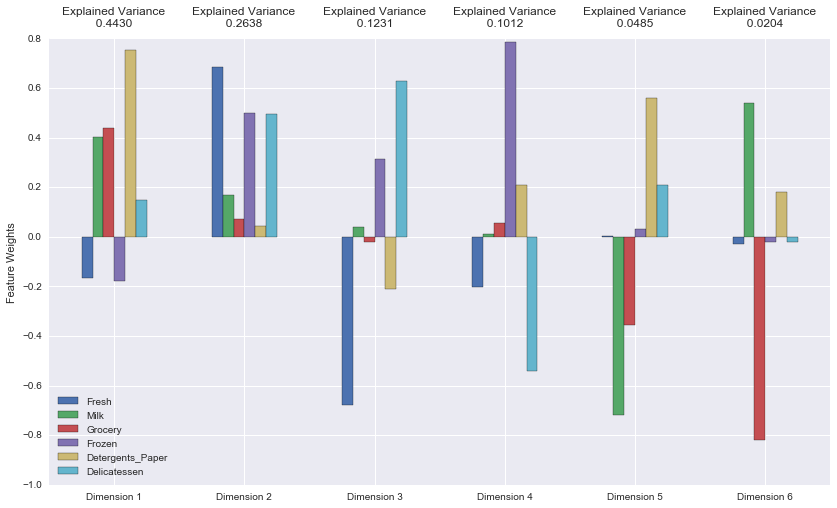

In [13]:
from sklearn.decomposition import PCA 
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 6)
pca = pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:** 

The sum of the first two principal components' explained variance is .7068. The sum of the first four is .9311.


The first dimension shows a primary weighting of Detergents_Paper with also a significant weighting of Milk and Grocery. This demonstrates that these three items are positively correlated with a high explained variance showing confidence in the correlation while the other three remain close to the zero axis and therefore are not correlated. Strong correlation means that customers with high spending in either of these three correlated categories should also mean that those customers demonstrate high spending in the other categories.

The second dimension show a primary weighting of Fresh, followed by Frozen, and Delicatessen with remaining labels staying close to zero. This indicates a correlation among the top three but the explained variance is low so the strength of correlation is low. 

The third dimension shows a significant negative correlation between Fresh adn Delicatessen in that the two bars reach far in opposite directions but the explained variance is low so our confidence in the strength of correlation should be low. 

The fourth dimension also shows a signficant negative correlation between Frozen and Delicatessen also with a low explained variance so a weak strength of correlation follows. 

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [14]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,3.1072,-2.7017,-0.6386,1.8708,-0.6452,-0.1333
1,4.3646,3.9519,-0.1229,0.6240,-0.5379,-0.0551
2,-1.7655,-0.4717,-0.9100,-0.9091,-0.1604,0.3293


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [15]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [16]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,3.1072,-2.7017
1,4.3646,3.9519
2,-1.7655,-0.4717


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

K-Means is a very fast clustering algorithm that works well when we are seeking a single label for each sample. It computes quickly but may require restarting when getting stuck in local minima. Gaussian Mixture Models work well when seeking labels tied to probabilities where there are not distinct margins between clusters of samples i.e. where clusters may overlap. GMMs also compute quickly but provide more information about the clustering than the single label.

Given the customer segments we have and the previous analysis, we can assume that there are not clearly dilineated clusters with margins that do not overlap. Because we have overlaps, I would recommend Gaussian Mixture Models. In doing so, we can always review the probabilities given in that model to check our assumption of overlaps and have a sense of how strong the clustering is.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [17]:
# import libraries
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

# TODO: Apply your clustering algorithm of choice to the reduced data 
# Set a range of Cluster Numbers to try
nClusters = range(2,11)
# Add the best option to the end of the list for the next step
nClusters.append(2)
# Loop through clustering options
for n in nClusters:
    clusterer = GMM(n_components=n, random_state=0)
    clusterer = clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, random_state=0)
    print "- For {0} Clusters, the Silhouette Score is {1:.4f}".format(n, score)

- For 2 Clusters, the Silhouette Score is 0.4118
- For 3 Clusters, the Silhouette Score is 0.3736
- For 4 Clusters, the Silhouette Score is 0.3082
- For 5 Clusters, the Silhouette Score is 0.2954
- For 6 Clusters, the Silhouette Score is 0.2765
- For 7 Clusters, the Silhouette Score is 0.3231
- For 8 Clusters, the Silhouette Score is 0.3121
- For 9 Clusters, the Silhouette Score is 0.2910
- For 10 Clusters, the Silhouette Score is 0.3120
- For 2 Clusters, the Silhouette Score is 0.4118


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

- For 2 Clusters, the Silhouette Score is 0.4118
- For 3 Clusters, the Silhouette Score is 0.3736
- For 4 Clusters, the Silhouette Score is 0.3082
- For 5 Clusters, the Silhouette Score is 0.2954
- For 6 Clusters, the Silhouette Score is 0.2765
- For 7 Clusters, the Silhouette Score is 0.3231
- For 8 Clusters, the Silhouette Score is 0.3121
- For 9 Clusters, the Silhouette Score is 0.2910
- For 10 Clusters, the Silhouette Score is 0.3120

The best Silhouette Scores are for 2,3,7 clusters in that order. 2 Clusters has the best overall score.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

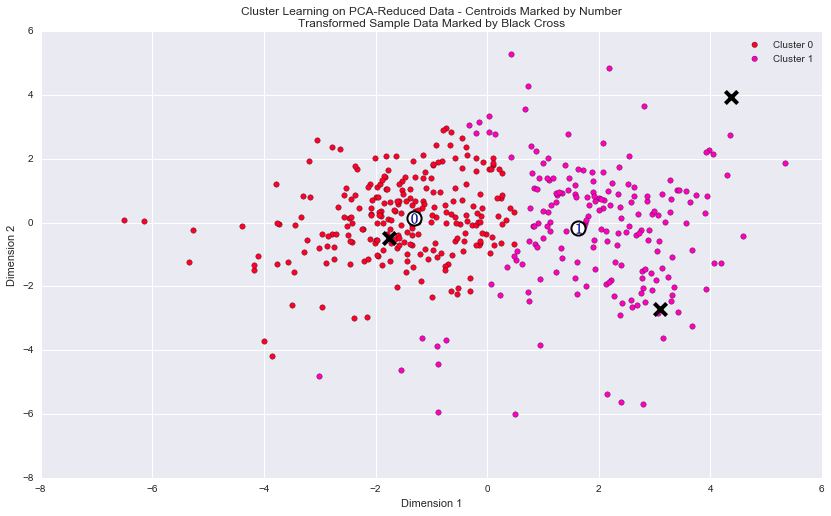

In [18]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8812.0,2052.0,2689.0,2058.0,337.0,712.0
Segment 1,4316.0,6347.0,9555.0,1036.0,3046.0,945.0


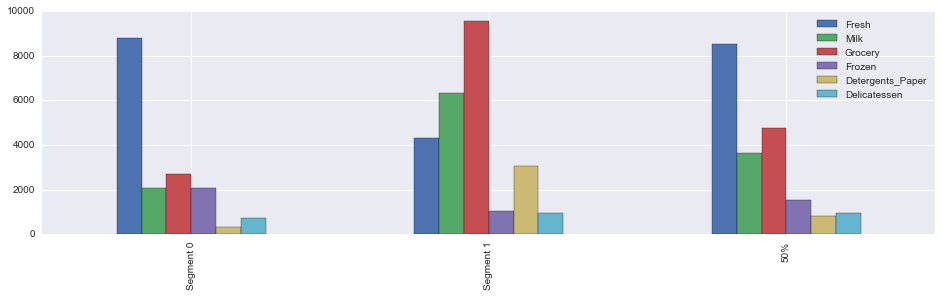

In [19]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

true_centers = true_centers.append(data.describe().ix['50%'])
true_centers.plot(kind = 'bar', figsize = (16, 4))

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

The two dimensions of the scatter plot should correspond with the labels "Detergents_Paper" in the X-Axis and "Fresh" in the Y-Axis because they had the highest feature weights in the first two dimensions of the Explained Variance graph. The elliptical grouping of the majority of points with these respective major and minor axes confirms this labeling of the graph axes. Therefore, Cluster 0 should identify with Segment 0 and Cluster 1 should identify with Segment 1. 

These two market segments could be described as Segment 0 being a cafe/restaurant and Segment 1 a market/supermarket. Segment 0 spends the most on Fresh compared to the other categories - presumably the consumables used in preparation. The Fresh category is above the median spend per the bar chart above while the only other category that is above or close to the the median is Frozen. All of the rest fall below the median spend value. Segment 1 has predominant spending on Grocery items, but Grocery, Milk, and Detergents_Paper all fall above the median spend values per the bar chart with Fresh well below the median and Frozen and Delicatessen at or below the median.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [56]:
# Print the pca samples to check coordinates for the scatter plot
# Display the True Centers in range of original values
display(true_centers[:-1])
# Convert the PCA Samples back to true values
log_pca_samples = pca.inverse_transform(pca_samples)
true_values = np.exp(log_pca_samples)
true_values_df = pd.DataFrame(np.round(true_values), columns = data.keys())
true_values_df.index = ['Sample 0', 'Sample 1', 'Sample 2']
# Display the True Values
display(true_values_df)

print "***Note the lowest euclidean value distance value for each row below***"
# Calculate the closest cluster point
from scipy.spatial.distance import cdist
cluster_distances = cdist(true_values_df, true_centers[:-1], 'euclidean')
cluster_df = pd.DataFrame(np.round(cluster_distances))
cluster_df.index = ['Sample 0', 'Sample 1', 'Sample 2']
cluster_df.columns = ['Segment 0', 'Segment 1']
display(cluster_df)
closest = np.argmin(cluster_distances, axis=1)
for i, found in enumerate(closest):
    print "The closest Cluster Center for Sample Point {0} is {1}".format(i, found)

# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred
    print "Prediction is {}".format(pred==closest[i])
    

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8812.0,2052.0,2689.0,2058.0,337.0,712.0
Segment 1,4316.0,6347.0,9555.0,1036.0,3046.0,945.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Sample 0,598.0,7510.0,15221.0,226.0,8260.0,339.0
Sample 1,46466.0,37848.0,42273.0,5039.0,28180.0,10952.0
Sample 2,6240.0,1542.0,2108.0,1641.0,233.0,491.0


***Note the lowest euclidean value distance value for each row below***


,Segment 0,Segment 1
Sample 0,17905.0,8688.0
Sample 1,71799.0,67729.0
Sample 2,2729.0,9525.0


The closest Cluster Center for Sample Point 0 is 1
The closest Cluster Center for Sample Point 1 is 1
The closest Cluster Center for Sample Point 2 is 0
Sample point 0 predicted to be in Cluster 1
Prediction is True
Sample point 1 predicted to be in Cluster 1
Prediction is True
Sample point 2 predicted to be in Cluster 0
Prediction is True


**Answer:**

Yes, all predictions are consistent with the smallest overall euclidean distance between the original (pre-processed) values. This coarse comparison gives us a sense of an intuitive proximity of the sample to the segment cluster center. This closeset cluster center index is compared against the pca prediction, and all match.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

Because of the nature of the divergent weighting of the products offered to our customers we should be able to assume better fit for the delivery schedule across the two segments. Our Cluster 1 Segment of the customers (market/supermarket) should be able to withstand a 3 days a week delivery schedule without much loss in service value because for one their differentiating factor is a larger spend on Detergents_Paper i.e. non-perishable goods. Secondly for their perishable purchases, they would more likely have refrigerated units to store products during the extended time between deliveries. Conversely our Cluster 0 Segment of customers (cafe/restaurant) purchase more "Fresh"/presumably perishable goods and would need fresh stock regularly. The opposite could be assumed for their ability to store goods between deliveries. They should be kept on the 5 day delivery schedule.  

To confirm these two hypotheses, performing an A/B test on both customer segments would give us the data we need to make a final business decision regarding delivery schedule. For each segment we can randomly split them in half for a control group A that remains on the current delivery schedule and the B group that gets a new 3 day schedule. After a given amount of time we can evaluate the customer feedback and cost savings across A and B segments to gather a sense of the performance of the hypothesis. From a business perspective, it should be noted that Segment 1 has an overall average spend that is 51% higher than Segment 0 so testing a delivery solution that has the potential of reflecting negatively on the service provided carries more risk for our revenue than experimenting on Segment 0. A solution to mitigating such risk could be to weight the percentage split across the A/B segments (as long as all comparisons take an even number of samples to assess).  

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

By adding the engineered feature to the customer data, we could use this updated data set as our training data for a supervised classification technique such as Random Forest or Support Vector Machines. Once we fit the model to the training data, we would be looking to predict (classify) the new customer into a target customer segment, 0 or 1 in the case that we keep two segments, based on their estimated product spending. 

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

In [ ]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliersB, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

Graphically it appears as though the clustering algorithm does reasonably well for this underlying distribution of customer types but there are plenty of points from the opposite label within each cluster. When we started we used the GMM because we assumed that there wouldn't be a clear margin between the clusters. Because we see overlap in the data points even after PCA, we were correct and we could query the probabilities for each point landing in the respective cluster to add more detail to our confidence in labeled cluster. These labels are very close to our segment descriptors.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.